## Road Sign Detection

[11/07/24 22:57:01] INFO     29406                                                                                                                 ]8;id=426924;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:45\2374171591.py]8;;\:]8;id=806625;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:45#__init__:45\__init__:45]8;;\

                    INFO     9803                                                                                                                  ]8;id=437547;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:45\2374171591.py]8;;\:]8;id=255124;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:45#__init__:45\__init__:45]8;;\

EPOCH: 1.000  trn_loss: 2.348  val_loss: 1.347  val_acc: 0.564  trn_acc: 0.318  (22.25s - 867.84s remaining)
EPOCH: 2.000  trn_loss: 1.037  val_loss: 0.832  val_acc: 0.725  trn_acc: 0.659  (46.94s - 891.82s remaining)
EPOCH: 3.000  trn_loss: 0.726  val_loss: 0.670  val_acc: 0.782  trn_acc: 0.760  (71.57s - 882.73s remaining)
EPOCH: 4.000  trn_loss: 0.582  val_loss: 0.586  val_acc: 0.805  trn_acc: 0.806  (96.21s - 865.91s remaining)
EPOCH: 5.000  trn_loss: 0.505  val_loss: 0.484  val_acc: 0.840  trn_acc: 0.833  (120.76s - 845.34s remaining)
EPOCH: 6.000  trn_loss: 0.460  val_loss: 0.451  val_acc: 0.856  trn_acc: 0.849  (145.33s - 823.52s remaining)
EPOCH: 7.000  trn_loss: 0.411  val_loss: 0.431  val_acc: 0.858  trn_acc: 0.865  (169.84s - 800.67s remaining)
EPOCH: 8.000  trn_loss: 0.385  val_loss: 0.449  val_acc: 0.854  trn_acc: 0.874  (194.48s - 777.92s remaining)
EPOCH: 9.000  trn_loss: 0.372  val_loss: 0.407  val_acc: 0.870  trn_acc: 0.880  (219.01s - 754.36s remaining)
EPOCH: 10.000 

100%|██████████| 141/141 [00:00<00:00, 148.65it/s]


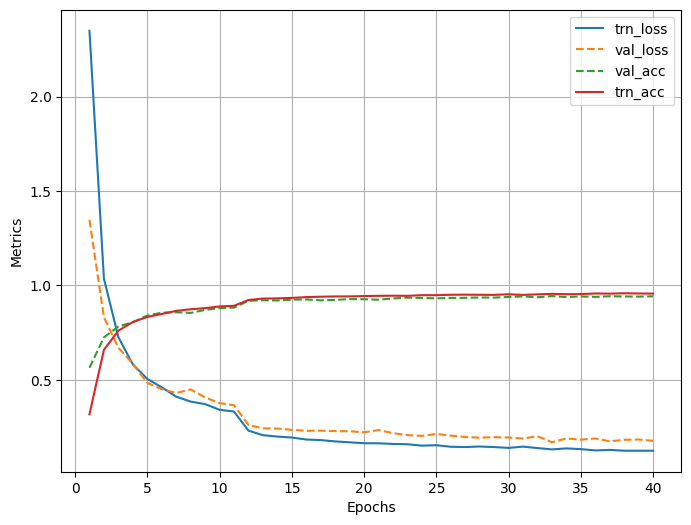

[11/07/24 23:13:20] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.16e+00 seconds                                                 ]8;id=683182;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:148\2374171591.py]8;;\:]8;id=65961;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\2374171591.py:148#<module>:148\<module>:148]8;;\

» no-aug-no-bn.log

In [1]:
from torch_snippets.torch_loader import Report
from torch_snippets import *
from torchvision import transforms as T
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split

classIds=pd.read_csv('../data/Ch6_2/signnames.csv')
classIds.set_index('ClassId',inplace=True)
classIds=classIds.to_dict()['SignName']
classIds={f'{k:05d}':v for k,v in classIds.items()}
id2int={k:ix for ix,(k,v) in enumerate(classIds.items())}

trn_tfms=T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229,0.224,0.225])
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        fpath=self.files[item]
        clss=fname(parent(str(fpath).replace('\\','/')))
        img=read(fpath,1)
        return img,clss
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self,batch):
        imgs,classes=list(zip(*batch))
        if self.transform:
            imgs=[self.transform(img)[None] for img in imgs]
        classes=[torch.tensor([id2int[clss.replace('\\','//').split('//')[-1]]]) for clss in classes]
        imgs,classes=[torch.cat(i).to(device) for i in [imgs,classes]]
        return imgs,classes
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('../data/Ch6_2/GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)


def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: 
        optimizer = Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

                    INFO     29406                                                                                                                 ]8;id=333040;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:30\4123734742.py]8;;\:]8;id=444642;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:30#__init__:30\__init__:30]8;;\

                    INFO     9803                                                                                                                  ]8;id=95211;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:30\4123734742.py]8;;\:]8;id=594130;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:30#__init__:30\__init__:30]8;;\

EPOCH: 1.000  trn_loss: 1.312  val_loss: 0.577  val_acc: 0.817  trn_acc: 0.608  (25.66s - 1000.87s remaining)
EPOCH: 2.000  trn_loss: 0.419  val_loss: 0.362  val_acc: 0.881  trn_acc: 0.865  (50.66s - 962.45s remaining)
EPOCH: 3.000  trn_loss: 0.290  val_loss: 0.281  val_acc: 0.910  trn_acc: 0.906  (75.65s - 932.96s remaining)
EPOCH: 4.000  trn_loss: 0.226  val_loss: 0.249  val_acc: 0.919  trn_acc: 0.928  (100.57s - 905.16s remaining)
EPOCH: 5.000  trn_loss: 0.197  val_loss: 0.219  val_acc: 0.927  trn_acc: 0.934  (125.51s - 878.59s remaining)
EPOCH: 6.000  trn_loss: 0.170  val_loss: 0.170  val_acc: 0.944  trn_acc: 0.944  (150.76s - 854.29s remaining)
EPOCH: 7.000  trn_loss: 0.154  val_loss: 0.175  val_acc: 0.945  trn_acc: 0.949  (176.69s - 832.96s remaining)
EPOCH: 8.000  trn_loss: 0.136  val_loss: 0.161  val_acc: 0.948  trn_acc: 0.955  (202.01s - 808.04s remaining)
EPOCH: 9.000  trn_loss: 0.116  val_loss: 0.153  val_acc: 0.951  trn_acc: 0.963  (227.38s - 783.20s remaining)
EPOCH: 10.00

100%|██████████| 141/141 [00:00<00:00, 147.37it/s]


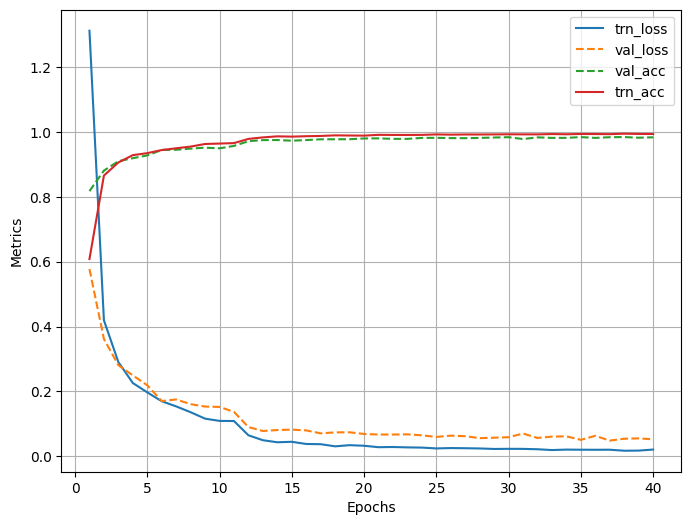

[11/07/24 23:30:12] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.16e+00 seconds                                                 ]8;id=901386;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:133\4123734742.py]8;;\:]8;id=924888;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\4123734742.py:133#<module>:133\<module>:133]8;;\

» no-aug-no-bn.log

In [2]:
trn_tfms=T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229,0.224,0.225])
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        fpath=self.files[item]
        clss=fname(parent(str(fpath).replace('\\','/')))
        img=read(fpath,1)
        return img,clss
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self,batch):
        imgs,classes=list(zip(*batch))
        if self.transform:
            imgs=[self.transform(img)[None] for img in imgs]
        classes=[torch.tensor([id2int[clss.replace('\\','//').split('//')[-1]]]) for clss in classes]
        imgs,classes=[torch.cat(i).to(device) for i in [imgs,classes]]
        return imgs,classes
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('../data/Ch6_2/GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)


def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: 
        optimizer = Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn1.log')

                    INFO     29406                                                                                                                 ]8;id=71051;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:30\3887793976.py]8;;\:]8;id=789551;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:30#__init__:30\__init__:30]8;;\

                    INFO     9803                                                                                                                  ]8;id=543841;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:30\3887793976.py]8;;\:]8;id=630334;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:30#__init__:30\__init__:30]8;;\

EPOCH: 1.000  trn_loss: 1.818  val_loss: 0.778  val_acc: 0.751  trn_acc: 0.469  (39.49s - 1540.17s remaining)
EPOCH: 2.000  trn_loss: 0.686  val_loss: 0.484  val_acc: 0.842  trn_acc: 0.781  (77.80s - 1478.17s remaining)
EPOCH: 3.000  trn_loss: 0.496  val_loss: 0.379  val_acc: 0.873  trn_acc: 0.837  (116.23s - 1433.46s remaining)
EPOCH: 4.000  trn_loss: 0.400  val_loss: 0.320  val_acc: 0.895  trn_acc: 0.871  (154.65s - 1391.88s remaining)
EPOCH: 5.000  trn_loss: 0.344  val_loss: 0.263  val_acc: 0.910  trn_acc: 0.887  (193.00s - 1351.01s remaining)
EPOCH: 6.000  trn_loss: 0.302  val_loss: 0.242  val_acc: 0.921  trn_acc: 0.902  (231.30s - 1310.70s remaining)
EPOCH: 7.000  trn_loss: 0.274  val_loss: 0.238  val_acc: 0.917  trn_acc: 0.909  (269.95s - 1272.63s remaining)
EPOCH: 8.000  trn_loss: 0.241  val_loss: 0.205  val_acc: 0.933  trn_acc: 0.920  (308.42s - 1233.68s remaining)
EPOCH: 9.000  trn_loss: 0.232  val_loss: 0.200  val_acc: 0.932  trn_acc: 0.923  (346.90s - 1194.89s remaining)
EPO

100%|██████████| 141/141 [00:01<00:00, 133.79it/s]


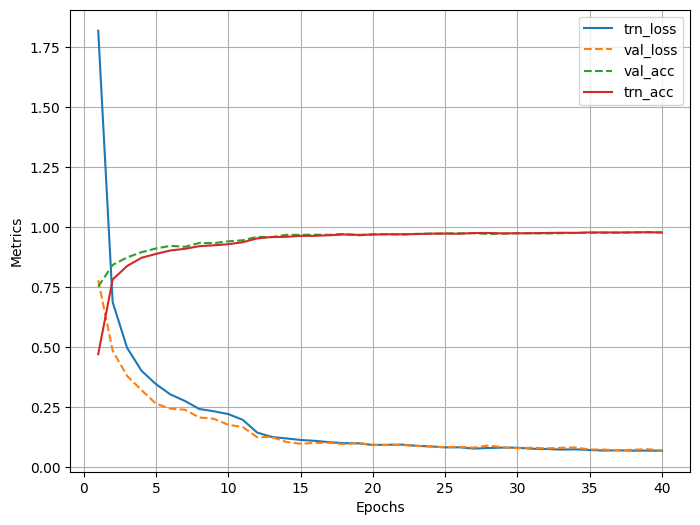

[11/07/24 23:57:27] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.34e+00 seconds                                                 ]8;id=62474;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:133\3887793976.py]8;;\:]8;id=659383;file://C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30516\3887793976.py:133#<module>:133\<module>:133]8;;\

» no-aug-no-bn.log

In [3]:
trn_tfms=T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229,0.224,0.225])
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        fpath=self.files[item]
        clss=fname(parent(str(fpath).replace('\\','/')))
        img=read(fpath,1)
        return img,clss
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self,batch):
        imgs,classes=list(zip(*batch))
        if self.transform:
            imgs=[self.transform(img)[None] for img in imgs]
        classes=[torch.tensor([id2int[clss.replace('\\','//').split('//')[-1]]]) for clss in classes]
        imgs,classes=[torch.cat(i).to(device) for i in [imgs,classes]]
        return imgs,classes
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('../data/Ch6_2/GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)


def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: 
        optimizer = Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn2.log')